## COVID-19 Group 2

### Importing required libraries

In [292]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta,date
import plotly.express as px 
import json, requests
from io import StringIO
import re
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import warnings
from IPython.display import Image

from scipy.stats import ttest_ind, ttest_ind_from_stats


warnings.filterwarnings('ignore')

%matplotlib inline

In [293]:
# Load CSV data directly from the URL with pandas
data = pd.read_csv(
    "gcp_covid19_countrylevel.csv",
      usecols=["date", "country_name", "total_confirmed", "total_deceased","average_temperature"],
      parse_dates=["date"]
    )

data

,date,country_name,total_confirmed,total_deceased,average_temperature
0,2020-01-01,Andorra,0.0,0.0,6.201389
1,2020-01-02,Andorra,0.0,0.0,5.340278
2,2020-01-03,Andorra,0.0,0.0,6.638889
3,2020-01-04,Andorra,0.0,0.0,7.375000
4,2020-01-05,Andorra,0.0,0.0,5.833333
...,...,...,...,...,...
79776,2020-11-14,Zimbabwe,8786.0,257.0,NaN
79777,2020-11-15,Zimbabwe,8786.0,257.0,NaN
79778,2020-11-16,Zimbabwe,NaN,NaN,NaN
79779,2020-11-17,Zimbabwe,NaN,NaN,NaN


In [294]:
dataset = data[data['country_name'].isin([ "France","Germany"])].copy()


In [295]:
# Defining Active Cases
dataset['Active'] = dataset['total_confirmed'] - dataset['total_deceased'] 

In [296]:
# Replace NAN and Missing Values with 0
dataset.fillna(pd.Series(0, index=dataset.select_dtypes(exclude='category').columns),inplace=True)

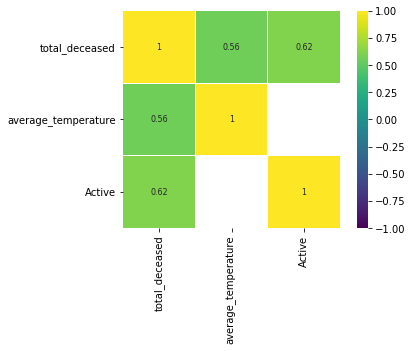

In [297]:
corr = dataset.drop('total_confirmed',axis=1).corr()
sns.heatmap(corr[(corr>0.5) | (corr <= -0.4)],cmap='viridis',vmax=1.0,vmin=-1.0,linewidth=0.1,annot=True,annot_kws={"size":8},square=True)

In [298]:
#print(dataset['average_temperature'].quantile(0.10))
#print(dataset['average_temperature'].quantile(0.90))

#4.5027775000000005
#20.966666500000002

print(dataset['total_confirmed'].quantile(0.10))
print(dataset['total_confirmed'].quantile(0.90))

#6.0
#540604.0

6.0
540604.0


In [299]:
# Checking Skewness:-1 and +1 (should be)


#dataset["average_temperature"] = np.where(dataset["average_temperature"] <4.5027775000000005, 4.5027775000000005,dataset['average_temperature'])
#dataset["average_temperature"] = np.where(dataset["average_temperature"] >20.966666500000002, 20.966666500000002,dataset['average_temperature'])
#print(dataset['average_temperature'].skew())

# -0.053932283151533325

dataset["total_confirmed"] = np.where(dataset["total_confirmed"] <6.0, 6.0,dataset['total_confirmed'])
dataset["total_confirmed"] = np.where(dataset["total_confirmed"] >540604.0, 540604.0,dataset['total_confirmed'])
print(dataset['total_confirmed'].skew())

# 0.8594921821959212

0.8594921821959212


In [300]:
# Replacing outliers with median of that column

median = float(dataset['average_temperature'].median())

dataset["average_temperature"] = np.where(dataset["average_temperature"] > median, median, dataset['average_temperature'])

dataset['average_temperature'].describe()

#count    646.000000
#mean      10.735317
#std        3.278170
#min        4.502778
#25%        8.069445
#50%       13.316667
#75%       13.316667
#max       13.316667
#Name: average_temperature, dtype: float64

median = float(dataset['total_confirmed'].median())

dataset["total_confirmed"] = np.where(dataset["total_confirmed"] > median, median, dataset['total_confirmed'])

dataset['total_confirmed'].describe()

#count       646.000000
#mean     114580.269350
#std       72531.789549
#min           6.000000
#25%       11399.250000
#50%      168912.000000
#75%      169014.000000
#max      169014.000000
#Name: total_confirmed, dtype: float64

count       646.000000
mean     114580.269350
std       72531.789549
min           6.000000
25%       11399.250000
50%      168912.000000
75%      169014.000000
max      169014.000000
Name: total_confirmed, dtype: float64

In [301]:
bins = [0, 1000, 5000, 10000]
labels = ["Not Critical","Worrying","Critical"]
dataset['State'] = pd.cut(dataset['total_confirmed'], bins=bins, labels=labels)


dataset['year'] = pd.DatetimeIndex(dataset['date']).year
dataset['month'] = pd.DatetimeIndex(dataset['date']).month
dataset['day'] = pd.DatetimeIndex(dataset['date']).day

bins = [0, 4, 8, 11]
labels = ["Jan-APR","APR-AUG","AUG-SEP"]
dataset['MonthsRange'] = pd.cut(dataset['month'], bins=bins, labels=labels)

dataFrame = pd.DataFrame(dataset, columns=['date','country_name','total_confirmed', 'total_deceased', 'average_temperature','MonthsRange'])
dataFrame

# From Jan-Apr
start_date = "2020-1-1"
end_date = "2020-3-1"

after_start_date = dataFrame["date"] >= start_date
before_end_date = dataFrame["date"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = dataFrame.loc[between_two_dates]

filtered_dates

temp = filtered_dates.groupby(['country_name'])['date','total_confirmed', 'total_deceased', 'average_temperature', 'MonthsRange'].max()
temp




,date,total_confirmed,total_deceased,average_temperature,MonthsRange
country_name,,,,,
France,2020-03-01,130.0,2.0,13.316667,Jan-APR
Germany,2020-03-01,129.0,0.0,12.538889,Jan-APR


In [302]:
# From Apr-Aug
start_date = "2020-4-1"
end_date = "2020-8-1"

after_start_date = dataFrame["date"] >= start_date
before_end_date = dataFrame["date"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = dataFrame.loc[between_two_dates]

filtered_dates

temp = filtered_dates.groupby(['country_name'])['date','total_confirmed', 'total_deceased', 'average_temperature', 'MonthsRange'].max()
temp


,date,total_confirmed,total_deceased,average_temperature,MonthsRange
country_name,,,,,
France,2020-08-01,169014.0,30265.0,13.316667,APR-AUG
Germany,2020-08-01,169014.0,9141.0,13.316667,APR-AUG


In [303]:
start_date = "2020-8-1"
end_date = "2020-11-1"

after_start_date = dataFrame["date"] >= start_date
before_end_date = dataFrame["date"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = dataFrame.loc[between_two_dates]

filtered_dates

temp = filtered_dates.groupby(['country_name'])['date','total_confirmed', 'total_deceased', 'average_temperature', 'MonthsRange'].max()
temp










,date,total_confirmed,total_deceased,average_temperature,MonthsRange
country_name,,,,,
France,2020-11-01,169014.0,30544.0,13.316667,AUG-SEP
Germany,2020-11-01,169014.0,10530.0,13.316667,AUG-SEP


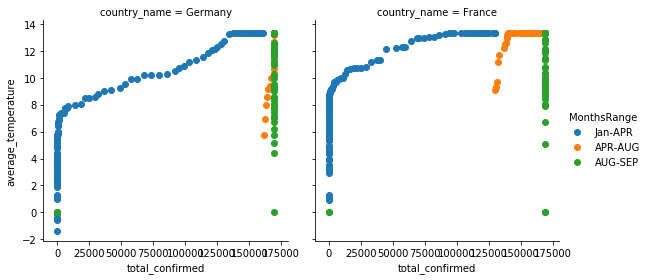

In [304]:
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)

g = sns.FacetGrid(dataFrame, hue="MonthsRange", col="country_name", height=4)
g.map(qqplot, "total_confirmed", "average_temperature")
g.add_legend()

In [306]:
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

countries = np.unique(dataset2['country_name'])
mean_temp = []
for country in countries:
    mean_temp.append(dataset2[dataset2['country_name'] == country]['average_temperature'].mean())
    
    # Building the data frame
    
data = [ dict(
        type = 'choropleth',
        locations = countries,
        z = mean_temp,
        locationmode = 'country names',
        text = countries,
        marker = dict(
            line = dict(color = 'rgb(0,0,0)', width = 1)),
            colorbar = dict(autotick = True, tickprefix = '', 
            title = 'Temperature')
            )
       ]

# Building the visual

layout = dict(
    title = 'Avg Temperature by Country',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )

fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='worldmap')

formated_gdf = dataset2.groupby(['date', 'country_name'])['total_confirmed', 'total_deceased'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['date'] = pd.to_datetime(formated_gdf['date'])
formated_gdf['date'] = formated_gdf['date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['total_confirmed'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="country_name", locationmode='country names', 
                     color="total_confirmed", size='size', hover_name="country_name", 
                     range_color= [0, max(formated_gdf['total_confirmed'])+2], 
                     projection="natural earth", animation_frame="date", 
                     title='spread of COVID-19 based on different time intervals')
fig.update(layout_coloraxis_showscale=False)
py.offline.iplot(fig)